# **ReactiveDissolution -- Results Visualization Notebook**

### General Imports

In [1]:
# General Imports
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import lightning as L

from functools import partial
from sklearn.model_selection import train_test_split

# Reactive Dissolution Imports
from data_loader import *
from preprocessing import *
from models.convlstm import ConvLSTM_Model
from models.tau import TAU_Model
from models.ufno import UFNO_Model

from utils import fix_randseeds, delete_arrays

### Loading Dataset
NOTE: Ensure that the settings match those from "main.py" file

In [2]:
TRAIN_FILES = 24
VAL_FILES = 8
extra_features = True

fix_randseeds(12345) 

dataset_path = "../reactflow/256modelruns"
dataset_files = sorted(os.listdir(dataset_path))

train_files, val_files = train_test_split(
    dataset_files, train_size=TRAIN_FILES, test_size=VAL_FILES)

data_list_train = read_full_dataset(
    train_files, dataset_path=dataset_path)

data_list_val = read_full_dataset(
    val_files, dataset_path=dataset_path)

dissolution_steps = 100
input_scaler_list = estimate_input_scalers(
    data_list_train, scaler_type='std')

in_steps = 5
out_steps = 5


../reactflow/256modelruns/Pe1_K1_2_2_1.hdf5
Loading the file: ../reactflow/256modelruns/Pe1_K1_2_2_1.hdf5
Keys: <KeysViewHDF5 ['C', 'Ux', 'Uy', 'eps', 'time']>
Done loading the variable C of shape: (260, 260, 101)
Done loading the variable Ux of shape: (260, 260, 101)
Done loading the variable Uy of shape: (260, 260, 101)
Done loading the variable eps of shape: (260, 260, 101)
Done loading the variable time of shape: (101,)
Done with ../reactflow/256modelruns/Pe1_K1_2_2_1.hdf5 == closing file now
../reactflow/256modelruns/Pe1_K1_2_2.hdf5
Loading the file: ../reactflow/256modelruns/Pe1_K1_2_2.hdf5
Keys: <KeysViewHDF5 ['C', 'Ux', 'Uy', 'eps', 'time']>
Done loading the variable C of shape: (260, 260, 101)
Done loading the variable Ux of shape: (260, 260, 101)
Done loading the variable Uy of shape: (260, 260, 101)
Done loading the variable eps of shape: (260, 260, 101)
Done loading the variable time of shape: (101,)
Done with ../reactflow/256modelruns/Pe1_K1_2_2.hdf5 == closing file now
..

### Setting Training / Validation Data

In [3]:
preprocess_data_cube = partial(
    preprocess_data_cube_extended,
    timesteps=dissolution_steps,
    out_steps=out_steps,
    outputs=['C', 'eps', 'Ux', 'Uy'])

dataset_train = DissolutionDataset(
    data_list_train,
    input_scaler_list,
    preprocess_data_cube_fnc=preprocess_data_cube,
    n_sample_files=TRAIN_FILES,
    dissolution_steps=dissolution_steps,
    in_steps=in_steps,
    out_steps=out_steps,
    extra_features=extra_features,
)

dataset_val = DissolutionDataset(
    data_list_val,
    input_scaler_list,
    preprocess_data_cube_fnc=preprocess_data_cube,
    n_sample_files=VAL_FILES,
    dissolution_steps=dissolution_steps,
    in_steps=in_steps,
    out_steps=out_steps,
    extra_features=extra_features,
)

Start of preprocess_data_cube
Done preprocess_data_cube
Start of preprocess_data_cube
Done preprocess_data_cube


### Scaling output data

In [4]:
output_scaler_list = estimate_output_scalers(
    dataset_train.Y, scaler_type='minmax')
scale_outputs(dataset_train, output_scaler_list)
scale_outputs(dataset_val, output_scaler_list)

### Iterative Stacking Prediction Function

In [5]:
def iterative_predictions(
    model_list,
    init_inputs,
    out_steps,
    input_scaler_list,
    output_scaler_list,
    total_steps=100,
    extra_features=False):

    total_levels = len(model_list)
    device = model_list[0].device
    corrections_dict = {}
    
    steps_per_file = total_steps - out_steps
    iterative_steps = steps_per_file // out_steps
    
    for level in range(total_levels):
        key = f"Level {level}"
        inputs = init_inputs.clone()
        model_list_slice = model_list[:level+1]
        level_outputs = []

        for _ in range(iterative_steps):
            for model in model_list_slice:
                approx = model(
                    inputs
                    .to(device)
                    .unsqueeze(0)).squeeze().detach().cpu()
                
                inputs = get_next_inputs(
                    approx,
                    input_scaler_list,
                    output_scaler_list,
                    extra_features)

            level_outputs.append(inputs)
            
        corrections_dict[key] = torch.cat(level_outputs)
        
    return corrections_dict

### Setting Base & Correction Models' Paths

In [6]:
from os.path import join as pjoin
model_basepath = "pretrained_models"

models_dict = {
    "ConvLSTM": {
        "ckpt_files": [
            pjoin("convlstm", "convlstm_level_0.ckpt"),
            pjoin("convlstm", "convlstm_level_1.ckpt"),
            pjoin("convlstm", "convlstm_level_2.ckpt"),
            pjoin("convlstm", "convlstm_level_3.ckpt"),
        ],
        "model_fn": ConvLSTM_Model,
        "model_list": [],
        "extra_features": True,
    },

    "U-FNO": {
        "ckpt_files": [
            pjoin("ufno", "ufno_level_0.ckpt"),
            pjoin("ufno", "ufno_level_1.ckpt"),
            pjoin("ufno", "ufno_level_2.ckpt"),
            pjoin("ufno", "ufno_level_3.ckpt"),            
        ],
        "model_fn": UFNO_Model,
        "model_list": [],
        "extra_features": True,
    },

    "TAU": {
        "ckpt_files": [
            pjoin("tau", "tau_level_0.ckpt"),
            pjoin("tau", "tau_level_1.ckpt"),
            pjoin("tau", "tau_level_2.ckpt"),
            pjoin("tau", "tau_level_3.ckpt"),
        ],
        "model_fn": TAU_Model,
        "model_list": [],
        "extra_features": True,
    },
}

### Loading checkpoints for all methods and correction levels

In [7]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

for method in models_dict:
    ckpt_files = models_dict[method]["ckpt_files"]
    model_fn = models_dict[method]["model_fn"]
    
    for f in ckpt_files:
        model = model_fn.load_from_checkpoint(
            os.path.join(model_basepath, f),
            out_channels=4).to(device)            
        model.eval()
        models_dict[method]["model_list"].append(model)

### Storing iterative prediction results (Training & Validation Set)

In [ ]:
# Creating a dictionary to store the results of the iterative predictions
all_results_train = {}
n_sample_files = dataset_train.n_sample_files
total_steps = dataset_train.dissolution_steps
steps_per_sample = dataset_train.steps_per_sample

for sample_file in range(n_sample_files): 
    key = f"Sample {sample_file + 1}"
    idx = steps_per_sample * sample_file
    all_results_train[key] = {}

    for method in models_dict:
        print(f"Training File {sample_file + 1} | {method}")
        model_list = models_dict[method]["model_list"]
        extra_ft = models_dict[method]["extra_features"]
        init_inputs, _ = dataset_train[idx]

        if extra_ft:
            in_channels = 7
        else:
            in_channels = 4
        
        results_dict = iterative_predictions(
            model_list,
            init_inputs[:, :in_channels],
            out_steps,
            input_scaler_list,
            output_scaler_list,
            extra_features=extra_ft)
        
        all_results_train[key][method] = results_dict


In [8]:
# Creating a dictionary to store the results of the iterative predictions
all_results_val = {}
n_sample_files = dataset_val.n_sample_files
total_steps = dataset_val.dissolution_steps
steps_per_sample = dataset_train.steps_per_sample

for sample_file in range(n_sample_files): 
    key = f"Sample {sample_file + 1}"
    idx = steps_per_sample * sample_file
    all_results_val[key] = {}

    for method in models_dict:
        print(f"Validation File {sample_file + 1} | {method}")
        model_list = models_dict[method]["model_list"]
        extra_ft = models_dict[method]["extra_features"]
        init_inputs, _ = dataset_val[idx]

        if extra_ft:
            in_channels = 7
        else:
            in_channels = 4
        
        results_dict = iterative_predictions(
            model_list,
            init_inputs[:, :in_channels],
            out_steps,
            input_scaler_list,
            output_scaler_list,
            extra_features=extra_ft)
        
        all_results_val[key][method] = results_dict


Validation File 1 | ConvLSTM


/home/mvmc2000/miniconda3/envs/reactflow/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Validation File 1 | U-FNO
Validation File 1 | TAU
Validation File 2 | ConvLSTM
Validation File 2 | U-FNO
Validation File 2 | TAU
Validation File 3 | ConvLSTM
Validation File 3 | U-FNO
Validation File 3 | TAU
Validation File 4 | ConvLSTM
Validation File 4 | U-FNO
Validation File 4 | TAU
Validation File 5 | ConvLSTM
Validation File 5 | U-FNO
Validation File 5 | TAU
Validation File 6 | ConvLSTM
Validation File 6 | U-FNO
Validation File 6 | TAU
Validation File 7 | ConvLSTM
Validation File 7 | U-FNO
Validation File 7 | TAU
Validation File 8 | ConvLSTM
Validation File 8 | U-FNO
Validation File 8 | TAU


# **Metrics & Plots**

### Preparing data to plot

In [9]:
OUTPUT_NAMES = ["C", "eps", "$U_x$", "$U_y$"]

def create_image_dict(results_dict, dataset, models_dict, input_scaler_list,
                      idx, out_idx=0, sample_file=1):
    
    samp_key = f'Sample {sample_file}'    
    idx_T = (100 * (sample_file-1)) + idx
    true_image = dataset.X[idx_T + in_steps, ..., out_idx].copy()
    out_name = OUTPUT_NAMES[out_idx]
    
    images_dict = {}

    for l in range(4):
        level = f"Level {l}"
    
        for method in models_dict:
            pred_image = results_dict[samp_key][method][level][idx, out_idx].clone()
            pred_image = input_scaler_list[out_idx].inverse_transform(pred_image)
            diff_image = pred_image - true_image
            
            corr = np.corrcoef(true_image.flatten(), pred_image.flatten())[0,1]
            key = f"{out_name} (Lv. {l}), PCC = {corr:.3f} | {method}"
            images_dict[key] = pred_image
            
            key = f"Diff (Lv. {l}) | {method}"
            images_dict[key] = diff_image

    return images_dict, true_image

### Plot Function for Visualizing Outputs and Differences to Ground Truth

In [10]:
from pathlib import Path
import seaborn as sns


def plot_results_with_diff(images, title=None, true_image=None, cols=3, save_as=None):
    n = len(images)
    rows = int(np.ceil(n / cols))
    
    _, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes_flat = np.ravel(axes)
    plt.suptitle(title, fontsize=28, y=1.02)
    
    for i in range(n, len(axes_flat)):
        axes_flat[i].axis('off')
    
    # Display each plot in the grid
    for i, (name, image) in enumerate(images.items()):
        if "Diff" in name:
            cmap = "seismic_r"
            center = 0
            max_diff = true_image.max() - true_image.min()
            vmin = -max_diff
            vmax = max_diff
            robust = True
        else:
            cmap = "viridis"
            center = None            
            vmin = true_image.min() if true_image is not None else None
            vmax = true_image.max() if true_image is not None else None
            robust = False
            
        sns.heatmap(
            image,
            cmap=cmap,
            center=center,
            vmin=vmin,
            vmax=vmax,
            robust=robust,
            ax=axes_flat[i],
            linewidth=0,
        )
        
        axes_flat[i].set_title(name, fontsize=14)
        axes_flat[i].set_xticks([])
        axes_flat[i].set_yticks([])
    
    plt.tight_layout()        
    
    if save_as:
        plt.savefig(
            save_as,
            format=Path(save_as).suffix.lstrip('.'),
            transparent=False,
            dpi=300,
        )

    plt.show()
    # plt.close("all")
    # plt.clf()

## Plot for a specific time step, channel and validation sample 

#### Example 1: Plotting C at time step 30

In [ ]:
idx = 24 # Choose a value from range [0, 94]

fn_params = {
    "results_dict": all_results_val,
    "dataset": dataset_val,
    "models_dict": models_dict,
    "input_scaler_list": input_scaler_list,
    "idx": idx,
    "out_idx": 0,
    "sample_file": 2,
}

title = f"Prediction Time Step: {idx+out_steps+1}"
save_as = os.path.join("pred_frames", "C", f"{idx:03d}.png")
images_dict, true_image = create_image_dict(**fn_params)

plot_results_with_diff(
    images_dict, 
    title=title, 
    true_image=true_image, 
    cols=6, 
    save_as=None)

#### Example 2: Plotting eps at time step 100

In [ ]:
idx = 94  # Choose a value from range [0, 94]

fn_params = {
    "results_dict": all_results_val,
    "dataset": dataset_val,
    "models_dict": models_dict,
    "input_scaler_list": input_scaler_list,
    "idx": idx,
    "out_idx": 1,
    "sample_file": 2,
}

title = f"Prediction Time Step: {idx+out_steps+1}"
save_as = os.path.join("pred_frames", "eps", f"{idx:03d}.png")
images_dict, true_image = create_image_dict(**fn_params)

plot_results_with_diff(
    images_dict, 
    title=title, 
    true_image=true_image, 
    cols=6, 
    save_as=None)

### Auxiliary functions for plotting Pearson Correlation Coefficient (PCC) curves

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE

out_names = ["c", "eps", "ux", "uy"]

def assign_linestyles(method_list):
    linestyle_dict = {}

    for method in method_list:
        if "ConvLSTM" in method:
            linestyle_dict[method] = "dashed"
        elif "U-FNO" in method:
            linestyle_dict[method] = "dotted"
        else:
            linestyle_dict[method] = "solid"

    return linestyle_dict


# Calculates all possible scores for all samples
# Metric options:
# - "MSE": Mean Squared Error
# - "PCC": Pearson Correlation Coefficient

def collect_all_scores(
    all_results, linestyle_dict, true_values, out_steps,
    timesteps=100, scaling_list=None, num_models=4, metric="MSE"):

    all_samples_scores = {
        m: {f"Level {l}": [list() for _ in range(4)] for l in range(num_models)}
        for m in linestyle_dict
    }
    steps_per_file = timesteps - out_steps

    for out_idx in range(4):
        T = true_values[:, out_idx]
        
        for file, sample in enumerate(all_results.keys()):
            start_T = (timesteps * file) + out_steps
    
            for method in linestyle_dict:
                for level in all_samples_scores[method]:
                    P = all_results[sample][method][level][:, out_idx].clone()
                    
                    if scaling_list is not None:
                        P = scaling_list[out_idx].inverse_transform(P)

                    if metric == "MSE":
                        scores_preds = torch.tensor([
                            MSE(T[start_T + k].flatten(), P[k].flatten())
                            for k in range(steps_per_file)])
                        
                    elif metric == "PCC":
                        scores_preds = torch.tensor([
                            np.corrcoef(T[start_T + k].flatten(), P[k].flatten())[0,1]
                            for k in range(steps_per_file)])
                        
                    else:
                        raise ValueError("Invalid metric. Choose 'MSE' or 'PCC'")
                             
                    all_samples_scores[method][level][out_idx].append(scores_preds)     

    return all_samples_scores

### Calculating PCC scores for all models, outputs and network levels

In [15]:
true_values_train = dataset_train.X.copy()
true_values_train = rearrange(true_values_train, "T H W C -> T C H W")

true_values_val = dataset_val.X.copy()
true_values_val = rearrange(true_values_val, "T H W C -> T C H W")

for k in range(4):
    true_values_train[:, k] = input_scaler_list[k].transform(true_values_train[:, k])
    true_values_val[:, k] = input_scaler_list[k].transform(true_values_val[:, k])

linestyle_dict = assign_linestyles(list(all_results_val["Sample 1"].keys()))

# linestyle_dict = {
#     'ConvLSTM (4 Features)': {'color': '#1f78b4', 'linestyle': '--'},   # Light Blue, Dashed
#     'ConvLSTM (7 Features)': {'color': '#1f78b4', 'linestyle': '-'},  # Darker Blue, Solid
#     'TAU (4 Features)': {'color': '#33a02c', 'linestyle': '--'},   # Light Green, Dashed
#     'TAU (7 Features)': {'color': '#33a02c', 'linestyle': '-'},  # Darker Green, Solid
#     'U-FNO (4 Features)': {'color': '#e31a1c', 'linestyle': '--'},   # Light Red, Dashed
#     'U-FNO (7 Features)': {'color': '#e31a1c', 'linestyle': '-'},  # Darker Red, Solid
# }

metric = "PCC"

# all_samples_scores_train = collect_all_scores(
#     all_results_train,
#     linestyle_dict,
#     true_values_train,
#     out_steps,
#     timesteps=100,
#     num_models=4,
#     metric=metric
# )

all_samples_scores_val = collect_all_scores(
    all_results_val,
    linestyle_dict,
    true_values_val,
    out_steps,
    timesteps=100,
    num_models=4,
    metric=metric
)

### Plotting all PCC curves (Validation Set)

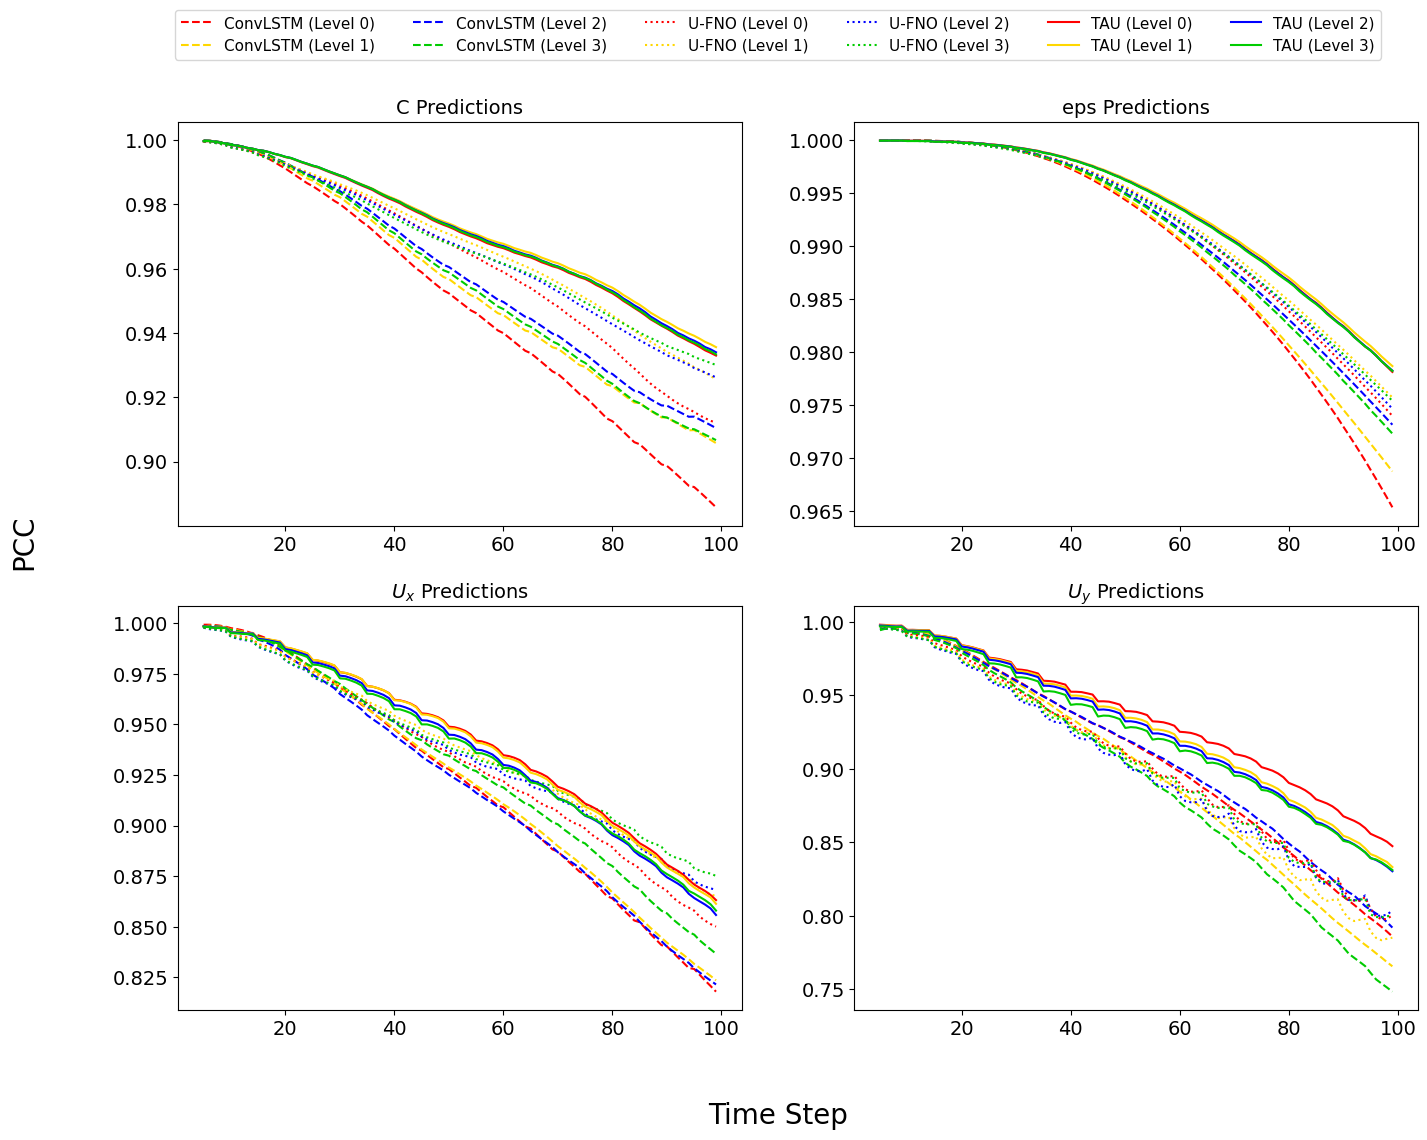

In [18]:
def plot_all_results(all_samples_scores, linestyle_dict, out_steps=5,
                    timesteps=100, save_as=None, format="pdf", metric="MSE"):
    steps_per_file = timesteps - out_steps
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    color_seq = ["#FF0000", "#FFD700", "#0000FF", "#00CC00"]
    
    for out_idx, ax in enumerate(axes):
        for method in linestyle_dict:
            for i, level in enumerate(all_samples_scores[method]):
                all_scores = torch.stack(all_samples_scores[method][level][out_idx])
                mean_scores = all_scores.mean(dim=0)
    
                sns.lineplot(
                    x=np.arange(out_steps, out_steps+steps_per_file),
                    y=mean_scores,
                    color=color_seq[i],
                    linestyle=linestyle_dict[method],
                    # label=method,
                    label=f"{method} ({level})",
                    legend=False,
                    ax=ax)
            
            ax.set_title(f"{OUTPUT_NAMES[out_idx]} Predictions", fontsize=14)
            ax.tick_params(axis="both", labelsize=14)
            # ax.set_xlabel("Time Step")
            ax.set_ylabel("")
    
    handles, labels = axes[0].get_legend_handles_labels()

    fig.supxlabel("Time Step", fontsize=20)
    fig.supylabel(metric, fontsize=20)
    fig.legend(
        handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95),
        ncol=6, columnspacing=2.5, fontsize=11)
    plt.subplots_adjust(top=0.85)
    # plt.tight_layout()

    if save_as is not None:
        fig.savefig(
            save_as, 
            format=format,
            transparent=True,
        )

# plot_all_results(
#     all_samples_scores_train,
#     linestyle_dict,
#     save_as=f"{metric}_train_scores.pdf",
#     metric=metric,
# )

plot_all_results(
    all_samples_scores_val,
    linestyle_dict,
    save_as=f"{metric}_val_scores.pdf",
    metric=metric,
)